In [1]:
import sys
# import climin
# from functools import partial
import warnings
import os
sys.path.append('..')

import numpy as np
# from scipy.stats import multinomial
# from scipy.linalg.blas import dtrmm

# import GPy
# from GPy.util import choleskies
# from GPy.core.parameterization.param import Param
# from GPy.kern import Coregionalize
# from GPy.likelihoods import Likelihood
# from GPy.util import linalg

from likelihoods.bernoulli import Bernoulli
from likelihoods.gaussian import Gaussian
# from likelihoods.categorical import Categorical
# from likelihoods.hetgaussian import HetGaussian
# from likelihoods.beta import Beta
# from likelihoods.gamma import Gamma
# from likelihoods.exponential import Exponential

# from hetmogp.util import draw_mini_slices
from hetmogp.het_likelihood import HetLikelihood
from hetmogp.svmogp import SVMOGP
from hetmogp import util
from hetmogp.util import vem_algorithm as VEM

import matplotlib.pyplot as plt
# from matplotlib.pyplot import gca
# from matplotlib import rc, font_manager
# from matplotlib import rcParams
# from matplotlib2tikz import save as tikz_save

warnings.filterwarnings("ignore")
os.environ['PATH'] = os.environ['PATH'] + ':/usr/texbin'

In [2]:
M = 8  # number of inducing points
Q = 2  # number of latent functions

# Heterogeneous Likelihood Definition
likelihoods_list = [Gaussian(sigma=1.), Bernoulli()] # Real + Binary
likelihood = HetLikelihood(likelihoods_list)
Y_metadata = likelihood.generate_metadata()
D = likelihood.num_output_functions(Y_metadata)

W_list, _ = util.random_W_kappas(Q, D, rank=1, experiment=True)

X1 = np.sort(np.random.rand(600))[:, None]
X2 = np.sort(np.random.rand(500))[:, None]
X = [X1, X2]

In [3]:
# True U and F functions
def experiment_true_u_functions(X_list):
    u_functions = []
    for X in X_list:
        u_task = np.empty((X.shape[0],2))
        u_task[:,0,None] = 4.5*np.cos(2*np.pi*X + 1.5*np.pi) - \
                           3*np.sin(4.3*np.pi*X + 0.3*np.pi) + \
                           5*np.cos(7*np.pi * X + 2.4*np.pi)
                
        u_task[:,1,None] = 4.5*np.cos(1.5*np.pi*X + 0.5*np.pi) + \
                   5*np.sin(3*np.pi*X + 1.5*np.pi) - \
                   5.5*np.cos(8*np.pi * X + 0.25*np.pi)

        u_functions.append(u_task)
    return u_functions


def experiment_true_f_functions(true_u, X_list):
    true_f = []
    W = W_lincombination()
    
    # D=1
    for d in range(2):
        f_d = np.zeros((X_list[d].shape[0], 1))
        for q in range(2):
            f_d += W[q][d].T*true_u[d][:,q,None]
        true_f.append(f_d)

    return true_f

# True Combinations
def W_lincombination():
    W_list = []
    # q=1
    Wq1 = np.array(([[-0.5],[0.1]]))
    W_list.append(Wq1)
    # q=2
    Wq2 = np.array(([[-0.1],[.6]]))
    W_list.append(Wq2)
    return W_list

In [4]:
# True functions values for inputs X
trueU = experiment_true_u_functions(X)
trueF = experiment_true_f_functions(trueU, X)

# Generating training data Y (sampling from heterogeneous likelihood)
Y = likelihood.samples(F=trueF, Y_metadata=Y_metadata) 

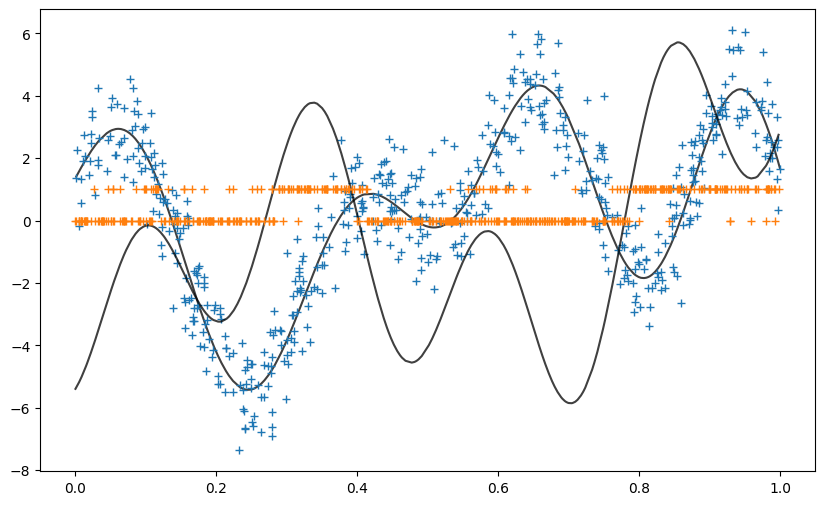

In [5]:
# Plot true parameter functions PFs (black) and heterogeneous data (blue, orange)
plt.figure(figsize=(10, 6))
Ntask = 2
for t in range(Ntask):
    plt.plot(X[t],trueF[t],'k-', alpha=0.75)
    plt.plot(X[t],Y[t],'+')
    
plt.show()

In [6]:
# Generating missing data (gap)
X2test = X[1][np.r_[351:450],:]
Y2test = Y[1][np.r_[351:450],:]

X2train_s1 = X[1][1:351,:]
X2train_s2 = X[1][450:,:]

X2 = np.delete(X2, np.s_[np.r_[351:450]],0)
Y2 = np.delete(Y[1], np.s_[np.r_[351:450]],0)


X = [X1, X2]
Y = [Y[0], Y2]

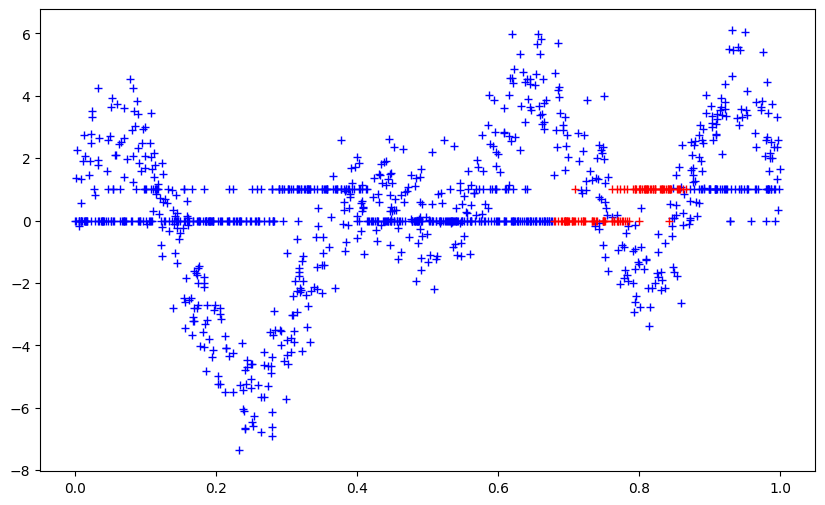

In [7]:
# Plot gap
plt.figure(figsize=(10, 6))
Ntask = 2
for t in range(Ntask):
    plt.plot(X[t],Y[t],'b+')
    
plt.plot(X2test, Y2test,'r+')
plt.show()
    

In [8]:
# KERNELS
ls_q = np.array(([.05]*Q))
var_q = np.array(([.5]*Q))
kern_list = util.latent_functions_prior(Q, lenghtscale=ls_q, variance=var_q, input_dim=1)

# # INDUCING POINTS
Z = np.linspace(0, 1, M)
Z = Z[:, np.newaxis]

In [9]:
# MODEL and INFERENCE
model = SVMOGP(X=X, Y=Y, Z=Z, kern_list=kern_list, likelihood=likelihood, Y_metadata=Y_metadata)
model = VEM(model, stochastic=False, vem_iters=5, optZ=True, verbose=False, verbose_plot=False, non_chained=True)

iteration (1) VE step, ELBO=[-1915.77239386]
iteration (1) VM step, ELBO=[-1247.92458195]
iteration (2) VE step, ELBO=[-1206.9608199]
iteration (2) VM step, ELBO=[-1177.14662121]
iteration (3) VE step, ELBO=[-1168.06671485]
iteration (3) VM step, ELBO=[-1167.12171072]
iteration (4) VE step, ELBO=[-1164.91948461]
iteration (4) VM step, ELBO=[-1164.91948461]
iteration (5) VE step, ELBO=[-1164.91948108]
iteration (5) VM step, ELBO=[-1164.91948108]


In [10]:
def plot_figure_gaplatex(model, Xtrain, Ytrain, Xtest, Ytest):
    sorted_Xtrain0 = np.sort(Xtrain[0])
    m_f_gaussian, v_f_gaussian = model.predictive_new(sorted_Xtrain0, output_function_ind=0)
    m_f_gaussian_upper = m_f_gaussian + 2*np.sqrt(v_f_gaussian)
    m_f_gaussian_lower = m_f_gaussian - 2*np.sqrt(v_f_gaussian)
    
    sorted_Xtrain1_s1 = np.sort(X2train_s1)
    m_f_ber, v_f_ber = model.predictive_new(sorted_Xtrain1_s1, output_function_ind=1)
    m_f_gp_upper = m_f_ber + 2*np.sqrt(v_f_ber)
    m_f_gp_lower = m_f_ber - 2*np.sqrt(v_f_ber)
    m_ber_gp_s1 = np.exp(m_f_ber)/ (1 + np.exp(m_f_ber))
    m_ber_gp_upper_s1 = np.exp(m_f_gp_upper)/ (1 + np.exp(m_f_gp_upper))
    m_ber_gp_lower_s1 = np.exp(m_f_gp_lower)/ (1 + np.exp(m_f_gp_lower))
    
    sorted_Xtrain1_s2 = np.sort(X2train_s2)
    m_f_ber, v_f_ber = model.predictive_new(sorted_Xtrain1_s2, output_function_ind=1)
    m_f_gp_upper = m_f_ber + 2*np.sqrt(v_f_ber)
    m_f_gp_lower = m_f_ber - 2*np.sqrt(v_f_ber)
    m_ber_gp_s2 = np.exp(m_f_ber)/ (1 + np.exp(m_f_ber))
    m_ber_gp_upper_s2 = np.exp(m_f_gp_upper)/ (1 + np.exp(m_f_gp_upper))
    m_ber_gp_lower_s2 = np.exp(m_f_gp_lower)/ (1 + np.exp(m_f_gp_lower))
    
    sorted_Xtest = np.sort(Xtest)
    m_pred_ber, v_pred_ber = model.predictive_new(sorted_Xtest, output_function_ind=1)
    m_pred_gp_upper = m_pred_ber + 2*np.sqrt(v_pred_ber)
    m_pred_gp_lower = m_pred_ber - 2*np.sqrt(v_pred_ber)
    m_pred_gp = np.exp(m_pred_ber)/ (1 + np.exp(m_pred_ber))
    m_pred_gp_upper = np.exp(m_pred_gp_upper)/ (1 + np.exp(m_pred_gp_upper))
    m_pred_gp_lower = np.exp(m_pred_gp_lower)/ (1 + np.exp(m_pred_gp_lower))
    
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    
    fig_gap_gaussian = plt.figure(figsize=(10, 5))
    plt.plot(Xtrain[0], Ytrain[0], 'x', color='blue', markersize=10, alpha=0.1)
    plt.plot(sorted_Xtrain0, m_f_gaussian, 'b-', linewidth=4, alpha=1)
    plt.plot(sorted_Xtrain0, m_f_gaussian_upper, 'b-', linewidth=4, alpha=0.25)
    plt.plot(sorted_Xtrain0, m_f_gaussian_lower, 'b-', linewidth=4, alpha=0.25)
    plt.title(r'Output 1: Gaussian Regression')
    plt.ylabel(r'Real Output')
    plt.xlabel(r'Real Input')
    plt.xlim(0,1)
    plt.show()
    
    fig_gap_bernoulli = plt.figure(figsize=(10, 5))
    plt.plot(X2, Y2, 'x', color='blue', markersize=10, alpha=0.1)
    plt.plot(Xtest, Ytest, 'x', color='red', markersize=10, alpha=0.1)
    
    plt.plot(sorted_Xtrain1_s1, m_ber_gp_s1, 'b-', linewidth=4, alpha=1)
    plt.plot(sorted_Xtrain1_s1, m_ber_gp_upper_s1, 'b-', linewidth=4, alpha=0.25)
    plt.plot(sorted_Xtrain1_s1, m_ber_gp_lower_s1, 'b-', linewidth=4, alpha=0.25)
    
    plt.plot(sorted_Xtrain1_s2, m_ber_gp_s2, 'b-', linewidth=4, alpha=1)
    plt.plot(sorted_Xtrain1_s2, m_ber_gp_upper_s2, 'b-', linewidth=4, alpha=0.25)
    plt.plot(sorted_Xtrain1_s2, m_ber_gp_lower_s2, 'b-', linewidth=4, alpha=0.25)
    
    plt.plot(sorted_Xtest, m_pred_gp, 'r-', linewidth=4, alpha=1)
    plt.plot(sorted_Xtest, m_pred_gp_upper, 'r-', linewidth=4, alpha=0.25)
    plt.plot(sorted_Xtest, m_pred_gp_lower, 'r-', linewidth=4, alpha=0.25)
    
    plt.title(r'Output 2: Binary Classification')
    plt.ylabel(r'Binary Output')
    plt.xlabel(r'Real Input')
    plt.xlim(0,1)
    plt.show()
    

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpj76jkzmm d174ba5a1278c3ea3324ab2ddb79f45c.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) (preloaded format=latex)
 restricted \write18 enabled.
fmtutil: fmtutil is using the following fmtutil.cnf files (in precedence order):
fmtutil:   h:/texlive/2023/texmf-dist/web2c/fmtutil.cnf
fmtutil: fmtutil is using the following fmtutil.cnf file for writing changes:
fmtutil:   c:/users/sara/.texlive2023/texmf-config/web2c/fmtutil.cnf
fmtutil [INFO]: writing formats under c:/users/sara/.texlive2023/texmf-var/web2c
fmtutil [INFO]: --- remaking latex with pdftex
fmtutil: running `pdftex -ini   -jobname=latex -progname=latex -translate-file=cp227.tcx *latex.ini' ...
This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) (INITEX)
 restricted \write18 enabled.
 (h:/texlive/2023/texmf-dist/web2c/cp227.tcx)
entering extended mode
(h:/texlive/2023/texmf-dist/tex/latex/latexconfig/latex.ini
(h:/texlive/2023/texmf-dist/tex/generic/tex-ini-files/pdftexconfig.tex)
(h:/texlive/2023/texmf-dist/tex/latex/base/latex.ltx
(h:/texlive/2023/texmf-dist/tex/latex/base/texsys.cfg)
./texsys.aux found


\@currdir set to: ./.


Assuming \openin and \input 
have the same search path.


Defining UNIX/DOS style filename parser.

catcodes, registers, parameters,
LaTeX2e <2023-06-01> patch level 1
(h:/texlive/2023/texmf-dist/tex/latex/l3kernel/expl3.ltx
(h:/texlive/2023/texmf-dist/tex/latex/l3kernel/expl3-code.tex)) hacks,
document commands, control, par, spacing, files, font encodings, lengths,
====================================

Local config file fonttext.cfg used

====================================
(h:/texlive/2023/texmf-dist/tex/latex/base/fonttext.cfg
(h:/texlive/2023/texmf-dist/tex/latex/base/fonttext.ltx
=== Don't modify this file, use a .cfg file instead ===

(h:/texlive/2023/texmf-dist/tex/latex/base/omlenc.def)
(h:/texlive/2023/texmf-dist/tex/latex/base/omsenc.def)
(h:/texlive/2023/texmf-dist/tex/latex/base/ot1enc.def)
(h:/texlive/2023/texmf-dist/tex/latex/base/t1enc.def)
(h:/texlive/2023/texmf-dist/tex/latex/base/ts1enc.def)
(h:/texlive/2023/texmf-dist/tex/latex/base/ts1cmr.fd)
(h:/texlive/2023/texmf-dist/tex/latex/base/t1cmr.fd)
(h:/texlive/2023/texmf-dist/tex/latex/base/ot1cmr.fd)
(h:/texlive/2023/texmf-dist/tex/latex/base/ot1cmss.fd)
(h:/texlive/2023/texmf-dist/tex/latex/base/ot1cmtt.fd)))
====================================

Local config file fontmath.cfg used

====================================
(h:/texlive/2023/texmf-dist/tex/latex/base/fontmath.cfg
(h:/texlive/2023/texmf-dist/tex/latex/base/fontmath.ltx
=== Don't modify this file, use a .cfg file instead ===

(h:/texlive/2023/texmf-dist/tex/latex/base/omlcmm.fd)
(h:/texlive/2023/texmf-dist/tex/latex/base/omscmsy.fd)
(h:/texlive/2023/texmf-dist/tex/latex/base/omxcmex.fd)
(h:/texlive/2023/texmf-dist/tex/latex/base/ucmr.fd)))
====================================

Local config file preload.cfg used

=====================================
(h:/texlive/2023/texmf-dist/tex/latex/base/preload.cfg
(h:/texlive/2023/texmf-dist/tex/latex/base/preload.ltx)) page nos., x-ref,
environments, center, verbatim, math definitions, boxes, title, sectioning,
contents, floats, footnotes, index, bibliography, output,
===========================================
Local configuration file hyphen.cfg used
===========================================
(h:/texlive/2023/texmf-dist/tex/generic/babel/hyphen.cfg
(h:/texlive/2023/texmf-dist/tex/generic/hyphen/hyphen.tex)
(h:/texlive/2023/texmf-dist/tex/generic/hyphen/dumyhyph.tex)
(h:/texlive/2023/texmf-dist/tex/generic/hyphen/zerohyph.tex)
(h:/texlive/2023/texmf-dist/tex/generic/dehyph-exptl/dehypht-x-2023-03-06.tex
dehyph-exptl: using an 8-bit TeX engine.
(h:/texlive/2023/texmf-dist/tex/generic/dehyph-exptl/dehypht-x-2023-03-06.pat
German Hyphenation Patterns (Traditional Orthography) `dehypht-x' 2023-03-06 (W
L)))
(h:/texlive/2023/texmf-dist/tex/generic/dehyph-exptl/dehyphn-x-2023-03-06.tex
dehyph-exptl: using an 8-bit TeX engine.
(h:/texlive/2023/texmf-dist/tex/generic/dehyph-exptl/dehyphn-x-2023-03-06.pat
German Hyphenation Patterns (Reformed Orthography, 2006) `dehyphn-x' 2023-03-06
 (WL)))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-af.tex
EC Afrikaans hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-ec.tex)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-af.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-grc.tex
Hyphenation patterns for Ancient Greek
(h:/texlive/2023/texmf-dist/tex/generic/hyphen/grahyph5.tex
Hyphenation patterns for Ancient Greek))
(h:/texlive/2023/texmf-dist/tex/generic/hyphen/ibyhyph.tex
Greek hyphenation patterns for Ibycus encoding, v3.0)
(h:/texlive/2023/texmf-dist/tex/generic/hyphen/zerohyph.tex)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-hy.tex
No Armenian hyphenation patterns - only for Unicode engines)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-eu.tex
EC Basque hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-ec.tex)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-eu.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-be.tex
T2A Belarusian hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-t2a.tex
) (h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-be.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-bg.tex
T2A Bulgarian hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-t2a.tex
) (h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-bg.tex
Bulgarian hyphenation patterns (options: --safe-morphology --standalone-tex, ve
rsion 21 October 2017)))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-ca.tex
EC Catalan hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-ec.tex)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-ca.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-zh-latn-pin
yin.tex EC Pinyin Hyphenation Patterns (with tone markers) 2018-11-25 (WL)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/ptex/hyph-zh-latn-pi
nyin.ec.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-cu.tex
No Church Slavonic hyphenation patterns - only for Unicode engines)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-cop.tex
Coptic hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex-8bit/copthyph.te
x)) (h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-hr.tex
EC Croatian hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-ec.tex)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-hr.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-cs.tex
EC Czech hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-ec.tex)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-cs.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-da.tex
EC Danish hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-ec.tex)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-da.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-nl.tex
EC Dutch hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-ec.tex)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-nl.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-en-gb.tex
ASCII Hyphenation patterns for British English
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-en-gb.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-en-us.tex
ASCII Hyphenation patterns for American English
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-en-us.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-eo.tex
IL3 Esperanto hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-il3.tex
) (h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-eo.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-et.tex
EC Estonian hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-ec.tex)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-et.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-mul-ethi.te
x No Pan-Ethiopic hyphenation patterns - only for Unicode engines)
(h:/texlive/2023/texmf-dist/tex/generic/hyphen/zerohyph.tex)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-fi.tex
EC Finnish hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-ec.tex)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-fi.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-fi-x-school
.tex EC Finnish hyphenation patterns for school
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-ec.tex)

(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-fi-x-school
.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-fr.tex
EC French hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-ec.tex)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-fr.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-fur.tex
EC Friulan hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-ec.tex)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-fur.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-gl.tex
EC Galician hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-ec.tex)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-gl.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-ka.tex
T8M Georgian hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-t8m.tex
) (h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-ka.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-de-1901.tex
EC German hyphenation patterns (traditional orthography)
(h:/texlive/2023/texmf-dist/tex/generic/dehyph/dehypht.tex
German Traditional Hyphenation Patterns `dehypht' Version 3.2a <1999/03/03>
(Formerly known under the name `ghyph31' and `ghyphen'.)))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-de-1996.tex
EC German hyphenation patterns (reformed orthography)
(h:/texlive/2023/texmf-dist/tex/generic/dehyph/dehyphn.tex
New German Hyphenation Patterns `dehyphn' Rev.31 <2001-05-07> (WaS)))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-de-ch-1901.
tex EC Swiss-German hyphenation patterns (traditional orthography)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-ec.tex)

(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-de-ch-1901.
tex
Swiss-German Hyphenation Patterns (Traditional Orthography) `dehyphts-x' 2021-0
2-26 (WL)))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-el-polyton.
tex Hyphenation patterns for multi-accent (polytonic) Modern Greek
(h:/texlive/2023/texmf-dist/tex/generic/hyphen/grphyph5.tex
Hyphenation patterns for multi-accent (polytonic) Modern Greek))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-el-monoton.
tex Hyphenation patterns for uni-accent (monotonic) Modern Greek
(h:/texlive/2023/texmf-dist/tex/generic/hyphen/grmhyph5.tex
Hyphenation patterns for uni-accent (monotonic) Modern Greek))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-hu.tex
EC Hungarian hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-ec.tex)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-hu.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-is.tex
EC Icelandic hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-ec.tex)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-is.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-as.tex
No Assamese hyphenation patterns - only for Unicode engines)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-bn.tex
No Bengali hyphenation patterns - only for Unicode engines)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-gu.tex
No Gujarati hyphenation patterns - only for Unicode engines)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-hi.tex
No Hindi hyphenation patterns - only for Unicode engines)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-kn.tex
No Kannada hyphenation patterns - only for Unicode engines)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-ml.tex
No Malayalam hyphenation patterns - only for Unicode engines)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-mr.tex
No Marathi hyphenation patterns - only for Unicode engines)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-or.tex
No Oriya hyphenation patterns - only for Unicode engines)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-pi.tex
No Pali hyphenation patterns - only for Unicode engines)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-pa.tex
No Panjabi hyphenation patterns - only for Unicode engines)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-ta.tex
No Tamil hyphenation patterns - only for Unicode engines)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-te.tex
No Telugu hyphenation patterns - only for Unicode engines)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-id.tex
ASCII Indonesian hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-id.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-ia.tex
ASCII Hyphenation patterns for Interlingua
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-ia.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-ga.tex
EC Irish hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-ec.tex)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-ga.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-it.tex
ASCII Italian hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-it.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-kmr.tex
EC Kurmanji hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-ec.tex)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-kmr.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-la-x-classi
c.tex EC Classical Latin hyphenation patterns, v.2.0 2019-07-03
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex-8bit/hyph-la-x-c
lassic.ec.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-la.tex
EC Latin hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-ec.tex)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-la.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-la-x-liturg
ic.tex EC Liturgical Latin hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/ptex/hyph-la-x-litur
gic.ec.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-lv.tex
L7X Latvian hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-l7x.tex
) (h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-lv.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-lt.tex
L7X Lithuanian hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-l7x.tex
) (h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-lt.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-mk.tex
MACEDONIAN Macedonian hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex-8bit/hyph-mk.mac
edonian.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-mn-cyrl.tex
T2A (New) Mongolian hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-t2a.tex
)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-mn-cyrl.tex
))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-mn-cyrl-x-l
mc.tex LMC Mongolian hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-lmc.tex
)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-mn-cyrl-x-l
mc.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-nb.tex
EC Norwegian Bokmal hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-ec.tex)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-nb.tex
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-no.tex)))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-nn.tex
EC Norwegian Nynorsk hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-ec.tex)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-nn.tex
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-no.tex)))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-oc.tex
EC Occitan hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-ec.tex)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-oc.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-pms.tex
ASCII Piedmontese hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-pms.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-pl.tex
QX Polish hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-qx.tex)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-pl.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-pt.tex
EC Portuguese hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-ec.tex)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-pt.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-ro.tex
EC Romanian hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-ec.tex)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-ro.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-rm.tex
ASCII Romansh hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-rm.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-ru.tex
T2A Russian hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/ruhyphen/ruhyphen.tex
(h:/texlive/2023/texmf-dist/tex/generic/ruhyphen/catkoi.tex)
(h:/texlive/2023/texmf-dist/tex/generic/ruhyphen/koi2t2a.tex)
(h:/texlive/2023/texmf-dist/tex/generic/ruhyphen/ruhyphal.tex)
(h:/texlive/2023/texmf-dist/tex/generic/ruhyphen/cyryoal.tex)
(h:/texlive/2023/texmf-dist/tex/generic/ruhyphen/hypht2.tex)))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-sa.tex
No Sanskrit hyphenation patterns - only for Unicode engines)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-sr-latn.tex
EC Serbian hyphenation patterns in Latin script
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-ec.tex)

(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-sh-latn.tex
))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-sr-cyrl.tex
T2A Serbian hyphenation patterns in Cyrillic script
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-t2a.tex
)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-sh-cyrl.tex
)) (h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-sk.tex
EC Slovak hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-ec.tex)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-sk.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-sl.tex
EC Slovenian hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-ec.tex)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-sl.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-es.tex
EC Spanish hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-ec.tex)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-es.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-sv.tex
EC Swedish hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-ec.tex)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-sv.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-th.tex
LTH Thai hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-lth.tex
) (h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-th.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-tr.tex
EC Turkish hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-ec.tex)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-tr.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-tk.tex
EC Turkmen hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-ec.tex)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-tk.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-uk.tex
T2A Ukrainian hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/ukrhyph/ukrhyph.tex
Ukrainian hyphenation patterns in t2a encoding
(h:/texlive/2023/texmf-dist/tex/generic/ukrhyph/catlcy.tex)
(h:/texlive/2023/texmf-dist/tex/generic/ukrhyph/lcy2t2a.tex)
(h:/texlive/2023/texmf-dist/tex/generic/ukrhyph/ukrhypmp.tex)
(h:/texlive/2023/texmf-dist/tex/generic/ruhyphen/hypht2.tex)))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-hsb.tex
EC Upper Sorbian hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-ec.tex)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-hsb.tex))
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/loadhyph/loadhyph-cy.tex
EC Welsh hyphenation patterns
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/conversions/conv-utf8-ec.tex)
(h:/texlive/2023/texmf-dist/tex/generic/hyph-utf8/patterns/tex/hyph-cy.tex)))
(h:/texlive/2023/texmf-dist/tex/generic/pdftex/glyphtounicode.tex)
(h:/texlive/2023/texmf-dist/tex/latex/base/utf8.def
(h:/texlive/2023/texmf-dist/tex/latex/base/omsenc.dfu)
(h:/texlive/2023/texmf-dist/tex/latex/base/ot1enc.dfu)
(h:/texlive/2023/texmf-dist/tex/latex/base/t1enc.dfu)
(h:/texlive/2023/texmf-dist/tex/latex/base/ts1enc.dfu))
(h:/texlive/2023/texmf-dist/tex/latex/firstaid/latex2e-first-aid-for-external-f
iles.ltx)
 ) )
Beginning to dump on file latex.fmt
 (preloaded format=latex 2024.2.28)
25066 strings of total length 486181
1916984 memory locations dumped; current usage is 204&359659
21652 multiletter control sequences
\font\nullfont=nullfont
\font\c__fp_exp_intarray=cmr10 at 0.00002pt
\font\c__fp_trig_intarray=cmr10 at 0.00003pt
\font\c_initex_cctab=cmr10 at 0.00005pt
\font\c_other_cctab=cmr10 at 0.00006pt
\font\c_str_cctab=cmr10 at 0.00008pt
\font\g_tmpa_cctab=cmr10 at 0.00009pt
\font\g_tmpb_cctab=cmr10 at 0.0001pt
\font\g__regex_state_active_intarray=cmr10 at 0.00012pt
\font\g__regex_thread_info_intarray=cmr10 at 0.00014pt
\font\g__regex_submatch_prev_intarray=cmr10 at 0.00015pt
\font\g__regex_submatch_begin_intarray=cmr10 at 0.00017pt
\font\g__regex_submatch_end_intarray=cmr10 at 0.00018pt
\font\g__regex_submatch_case_intarray=cmr10 at 0.0002pt
\font\g__regex_balance_intarray=cmr10 at 0.00021pt
\font\g__codepoint_category_index_intarray=cmr10 at 0.00023pt
\font\g__codepoint_uppercase_index_intarray=cmr10 at 0.00024pt
\font\g__codepoint_lowercase_index_intarray=cmr10 at 0.00026pt
\font\g__codepoint_category_blocks_intarray=cmr10 at 0.00027pt
\font\g__codepoint_uppercase_blocks_intarray=cmr10 at 0.00029pt
\font\g__codepoint_lowercase_blocks_intarray=cmr10 at 0.0003pt
\font\OMX/cmex/m/n/10=cmex10
\font\tenln=line10
\font\tenlnw=linew10
\font\tencirc=lcircle10
\font\tencircw=lcirclew10
\font\OT1/cmr/m/n/5=cmr5
\font\OT1/cmr/m/n/7=cmr7
\font\OT1/cmr/m/n/10=cmr10
\font\OML/cmm/m/it/5=cmmi5
\font\OML/cmm/m/it/7=cmmi7
\font\OML/cmm/m/it/10=cmmi10
\font\OMS/cmsy/m/n/5=cmsy5
\font\OMS/cmsy/m/n/7=cmsy7
\font\OMS/cmsy/m/n/10=cmsy10
\font\c_code_cctab=cmr10 at 0.00032pt
\font\c_document_cctab=cmr10 at 0.00034pt
558062 words of font info for 36 preloaded fonts
1141 hyphenation exceptions
Hyphenation trie of length 428911 has 8835 ops out of 35111
  143 for language 86
  110 for language 85
  138 for language 84
  7 for language 83
  12 for language 82
  53 for language 81
  127 for language 80
  195 for language 79
  71 for language 78
  248 for language 77
  62 for language 76
  66 for language 75
  119 for language 73
  43 for language 72
  58 for language 71
  7 for language 70
  194 for language 69
  37 for language 68
  23 for language 67
  852 for language 66
  852 for language 65
  21 for language 64
  38 for language 63
  38 for language 62
  77 for language 61
  58 for language 60
  206 for language 59
  25 for language 58
  216 for language 57
  27 for language 56
  37 for language 55
  229 for language 54
  38 for language 53
  21 for language 52
  147 for language 39
  185 for language 38
  18 for language 37
  50 for language 36
  420 for language 35
  235 for language 34
  207 for language 33
  39 for language 32
  76 for language 31
  40 for language 30
  89 for language 29
  6 for language 28
  31 for language 27
  113 for language 24
  145 for language 23
  377 for language 22
  224 for language 21
  265 for language 20
  60 for language 19
  63 for language 18
  19 for language 17
  14 for language 16
  3 for language 14
  21 for language 13
  54 for language 12
  36 for language 11
  5 for language 10
  148 for language 7
  97 for language 6
  137 for language 5
  440 for language 4
  440 for language 3
  2 for language 1
  181 for language 0
0 words of pdfTeX memory
0 indirect objects
No pages of output.
Transcript written on latex.log.
fmtutil [INFO]: log file copied to: c:/users/sara/.texlive2023/texmf-var/web2c/pdftex/latex.log
fmtutil [INFO]: c:/users/sara/.texlive2023/texmf-var/web2c/pdftex/latex.fmt installed.
fmtutil [INFO]: disabled formats: 3
fmtutil [INFO]: successfully rebuilt formats: 1
fmtutil [INFO]: not selected formats: 51
fmtutil [INFO]: total formats: 55
fmtutil [INFO]: 
*************************************************************
*                                                           *
* WARNING: you are switching to fmtutil's per-user formats. *
*         Please read the following warnings!               *
*                                                           *
*************************************************************

You have run fmtutil-user (as opposed to fmtutil-sys) for the first time;
this has created format files which are local to your personal account.

From now on, any changes in system formats will *not* be automatically
reflected in your files; furthermore, running fmtutil-sys will no longer
have any effect for you.

As a consequence, you yourself have to rerun fmtutil-user after any
change in the system directories. For example, when one of the LaTeX or
other format source files changes, which happens frequently.
See https://tug.org/texlive/scripts-sys-user.html for details.

If you want to undo this, remove the files mentioned above.

Run fmtutil --help for full documentation of fmtutil.
fmtutil [INFO]: exiting with status 0
Running the command H:\texlive\2023\bin\windows\fmtutil-user.exe
I can't find the format file `latex.fmt'!

kpathsea: Running mktexfmt latex.fmt

The command name is H:\texlive\2023\bin\windows\mktexfmt




<Figure size 1000x500 with 1 Axes>

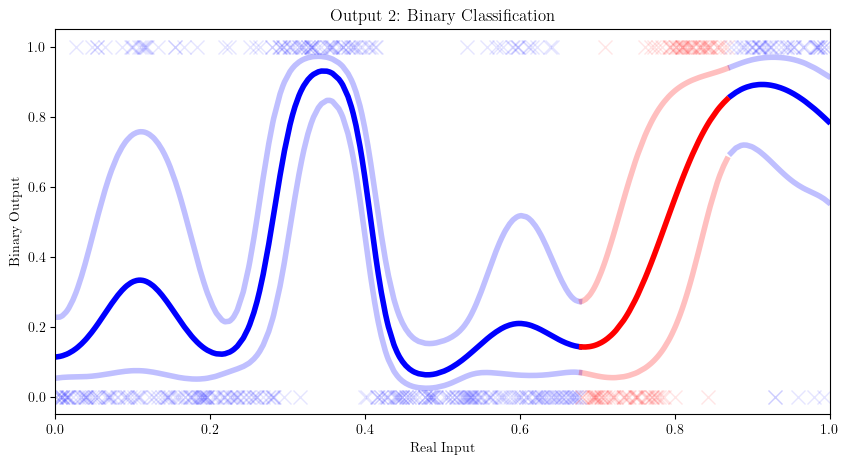

In [11]:
plot_figure_gaplatex(model, X, Y, X2test, Y2test)